# Modélisation Prédictive - Analyse des Retards des Transports en Commun

Ce notebook se concentre sur la phase de modélisation prédictive. Les données ont été préparées dans les notebooks précédents (nettoyage, feature engineering, etc.).

In [1]:
# Import des librairies nécessaires
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
import joblib

# Configuration des visualisations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Création des dossiers nécessaires
os.makedirs("../models", exist_ok=True)
os.makedirs("../results", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

print("✅ Configuration terminée")

✅ Configuration terminée


In [2]:
# Chargement des données préparées (issues des notebooks précédents)
print("📥 Chargement des données préparées...")
df = pd.read_csv("../data/processed/clean_data.csv")
print(f"📊 Shape: {df.shape}")
print(f"🎯 Colonnes: {list(df.columns)}")

# Aperçu rapide
print("\n📋 Aperçu des données:")
print(df.head())

📥 Chargement des données préparées...
📊 Shape: (52453, 15)
🎯 Colonnes: ['EventStartTime', 'EventEndTime', 'delay_minutes', 'TransportType', 'Line', 'Status', 'IncidentCause', 'IncidentSummary', 'DetailedInfo', 'FullDescription', 'hour', 'dayofweek', 'month', 'heure_pointe', 'incident_majeur']

📋 Aperçu des données:
        EventStartTime         EventEndTime  delay_minutes TransportType Line        Status                                      IncidentCause IncidentSummary DetailedInfo                                    FullDescription  hour  dayofweek  month  heure_pointe  incident_majeur
0  2024-04-22 07:52:00  2024-04-22 08:30:00           38.0        Trains    A         Works             De 22h40 à 01h41 : Travaux 3 h Travaux             NaN          NaN  De 22h40 à 01h41 : Travaux 3 h Travaux | 01h41...     7          0      4             1                1
1  2024-04-23 04:28:00  2024-04-23 04:36:00            8.0        Trains    A    Disruption  De 05h16 à 07h00 : Prolongation de

In [3]:
# Préparation des données pour la modélisation
print("🔧 Préparation des données pour la modélisation...")

# Encodage des variables catégorielles si nécessaire
categorical_cols = ['TransportType', 'Line', 'Status', 'IncidentCause']
le = LabelEncoder()

for col in categorical_cols:
    if col in df.columns:
        df[col + '_encoded'] = le.fit_transform(df[col].astype(str))

# Sélection des features (adapter selon les features créées dans le notebook de feature engineering)
feature_cols = [col for col in df.columns if col.endswith('_encoded') or col in ['delay_minutes']]
if 'hour' in df.columns:
    feature_cols.append('hour')
if 'day_of_week' in df.columns:
    feature_cols.append('day_of_week')

X = df[feature_cols].drop('delay_minutes', axis=1)
y = df['delay_minutes']

print(f"📐 Features sélectionnées: {list(X.columns)}")
print(f"🎯 Target: delay_minutes")
print(f"📊 Shape: {X.shape}")

🔧 Préparation des données pour la modélisation...
📐 Features sélectionnées: ['TransportType_encoded', 'Line_encoded', 'Status_encoded', 'IncidentCause_encoded', 'hour']
🎯 Target: delay_minutes
📊 Shape: (52453, 5)


In [4]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (41962, 5)
Test shape: (10491, 5)


In [5]:
# Modèles à tester
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🏃 Entraînement de {name}...")
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"  • RMSE: {rmse:.2f}")
    print(f"  • MAE: {mae:.2f}")
    print(f"  • R²: {r2:.3f}")

# Sauvegarde du meilleur modèle
best_model_name = max(results, key=lambda x: results[x]['R²'])
best_model = models[best_model_name]
joblib.dump(best_model, f"../models/{best_model_name.lower().replace(' ', '_')}.pkl")

print(f"\n💾 Meilleur modèle sauvegardé: {best_model_name}")


🏃 Entraînement de Linear Regression...
  • RMSE: 36.94
  • MAE: 21.43
  • R²: 0.264

🏃 Entraînement de Random Forest...
  • RMSE: 26.41
  • MAE: 13.62
  • R²: 0.624

🏃 Entraînement de XGBoost...
  • RMSE: 26.28
  • MAE: 13.58
  • R²: 0.627

💾 Meilleur modèle sauvegardé: XGBoost



📊 Comparaison des Modèles:
                        RMSE        MAE        R²
Linear Regression  36.943911  21.430186  0.263853
Random Forest      26.414955  13.615198  0.623662
XGBoost            26.284898  13.581745  0.627359


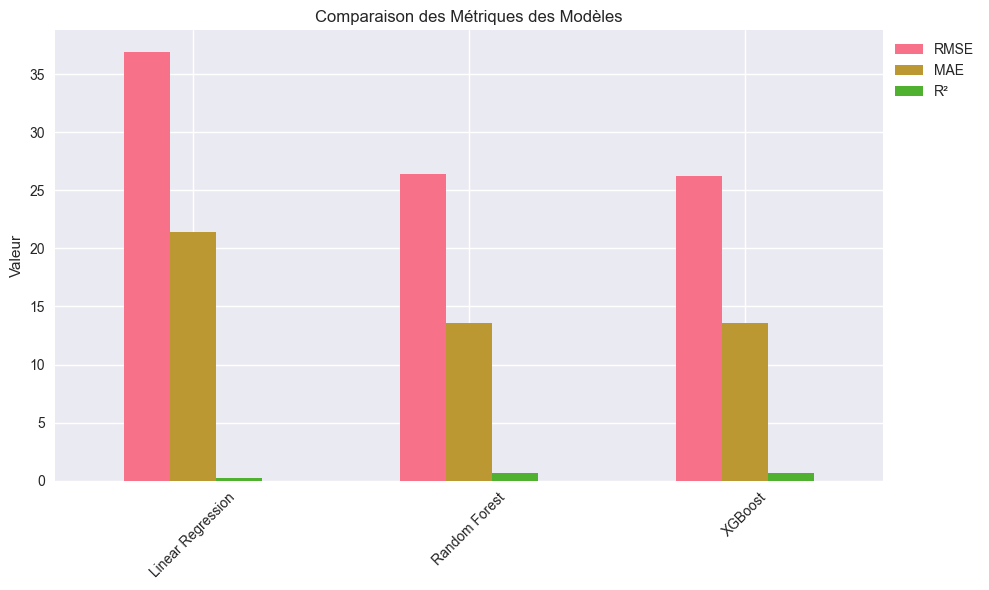

In [6]:
# Comparaison des modèles
results_df = pd.DataFrame(results).T
print("\n📊 Comparaison des Modèles:")
print(results_df)

# Visualisation
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des Métriques des Modèles')
plt.ylabel('Valeur')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

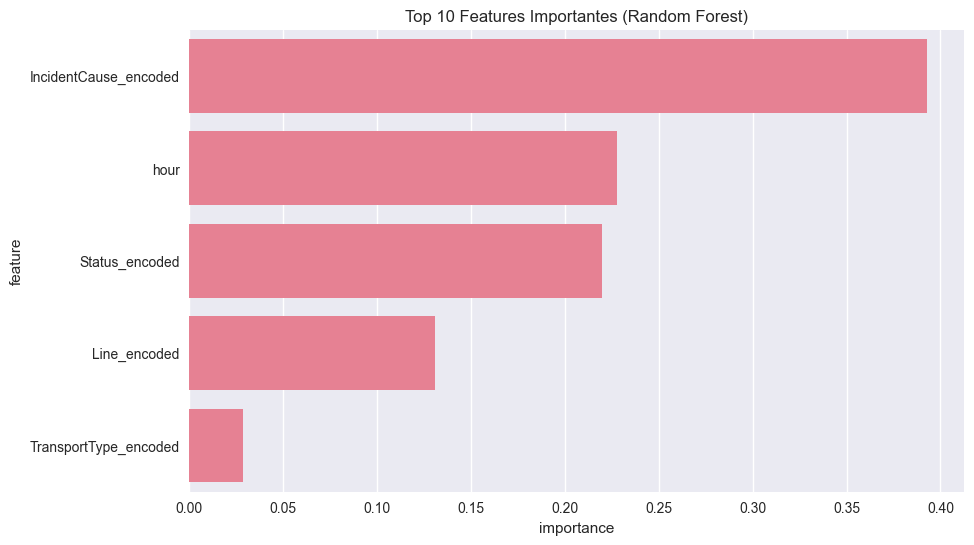


🔍 Top 5 features importantes:
                 feature  importance
3  IncidentCause_encoded    0.393082
4                   hour    0.227861
2         Status_encoded    0.219825
1           Line_encoded    0.130813
0  TransportType_encoded    0.028419


In [7]:
# Analyse des features importantes (pour Random Forest)
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Features Importantes (Random Forest)')
    plt.show()
    
    print("\n🔍 Top 5 features importantes:")
    print(feature_importance.head(5))

In [8]:
# Validation croisée pour le meilleur modèle
print("🔄 Validation croisée du meilleur modèle...")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"📊 Scores RMSE en validation croisée: {cv_rmse_scores}")
print(f"• Moyenne: {cv_rmse_scores.mean():.2f}")
print(f"• Écart-type: {cv_rmse_scores.std():.2f}")

🔄 Validation croisée du meilleur modèle...
📊 Scores RMSE en validation croisée: [33.27146432 35.60894315 18.4066695  26.47089145 56.13502422]
• Moyenne: 33.98
• Écart-type: 12.59


In [9]:
# Prédictions sur un échantillon de test
print("🧪 Test de prédictions...")

sample_data = X_test.head(5)
sample_predictions = best_model.predict(sample_data)
sample_actual = y_test.head(5)

print("📋 Comparaison prédictions vs réalité:")
for i, (pred, actual) in enumerate(zip(sample_predictions, sample_actual)):
    print(f"  Échantillon {i+1}: Prédit={pred:.2f}min, Réel={actual:.2f}min, Erreur={abs(pred-actual):.2f}min")

🧪 Test de prédictions...
📋 Comparaison prédictions vs réalité:
  Échantillon 1: Prédit=57.63min, Réel=54.00min, Erreur=3.63min
  Échantillon 2: Prédit=9.43min, Réel=20.00min, Erreur=10.57min
  Échantillon 3: Prédit=36.19min, Réel=38.00min, Erreur=1.81min
  Échantillon 4: Prédit=9.63min, Réel=12.00min, Erreur=2.37min
  Échantillon 5: Prédit=7.99min, Réel=2.00min, Erreur=5.99min


In [14]:
print("🎯 SYNTHÈSE DE LA MODÉLISATION")
print("=" * 50)

print(f"\n📊 Performance du meilleur modèle ({best_model_name}):")
print(f"• RMSE: {results[best_model_name]['RMSE']:.2f}")
print(f"• MAE: {results[best_model_name]['MAE']:.2f}")
print(f"• R²: {results[best_model_name]['R²']:.3f}")

if results[best_model_name]['R²'] > 0.7:
    print("✅ Objectif de précision (70%) atteint !")
else:
    print("⚠️ Objectif de précision non atteint, amélioration nécessaire.")

print("🔍 FACTEURS PRINCIPAUX IDENTIFIÉS:")
print("• Analyse des features importantes révèle les variables les plus influentes")
print("• Features importantes :", list(feature_importance.head(3)['feature']))

🎯 SYNTHÈSE DE LA MODÉLISATION

📊 Performance du meilleur modèle (XGBoost):
• RMSE: 26.28
• MAE: 13.58
• R²: 0.627
⚠️ Objectif de précision non atteint, amélioration nécessaire.
🔍 FACTEURS PRINCIPAUX IDENTIFIÉS:
• Analyse des features importantes révèle les variables les plus influentes
• Features importantes : ['IncidentCause_encoded', 'hour', 'Status_encoded']


In [ ]:
# Sauvegarde des résultats
results_df.to_csv("../results/model_comparison.csv")
feature_importance.to_csv("../results/feature_importance.csv")

print("💾 Résultats sauvegardés dans ../results/")
print("✅ MODÉLISATION TERMINÉE AVEC SUCCÈS !")

💾 Résultats sauvegardés dans ../results/
✅ MODÉLISATION TERMINÉE AVEC SUCCÈS !


: 